In [151]:
# import
import phd_plot_style
import numpy as np
import matplotlib.pyplot as plt
import random
from math import pi, sqrt
from scipy.special import erf 
import os

# load style file
import matplotlib.font_manager
import matplotlib as mpl
import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)

pub_fig_style = phd_plot_style.phd_revtex_plots()


# magic commands
%matplotlib inline
%config InlineBackend.print_figure_kwargs
%config InlineBackend.print_figure_kwargs={'bbox_inches':None, 'dpi': 200}

# Colors
cBlues = sns.color_palette("Blues_r", n_colors=9)#[::3]
cOranges = sns.color_palette("Oranges_r", n_colors=7)#[::3]#[1:-1]
cGreens = sns.color_palette("Greens_r", n_colors=7)#[::3]#[1:-1]
cPurples = sns.color_palette("Purples_r", n_colors=7)#[::3]#[1:-1]
cGreys = sns.color_palette("PuRd_r", n_colors=7)#[::3]#[1:-1]
color_zip = [cPurples, cBlues, cOranges, cGreens, cGreys]

# define dimensions
fig_width  = pub_fig_style.revtex_sizes_active["page.columnwidth"] * pub_fig_style.tex_pt_to_inch
fig_height = pub_fig_style._get_revtex_rc()["figure.figsize"][1]

import matplotlib.pylab as pylab
params = {'legend.fontsize':'large',
         'axes.labelsize':'small',
         'axes.titlesize':'small',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

def file_reader(fname_in,repeat):
    first = True
    for i_rep in range(repeat):
        fname = fname_in + "_i_%d.npz" % (i_rep)

        if os.path.exists(fname):
            npz_file = np.load(fname)
            succ_prob, p_list, Nrep = npz_file['succ_prob'], npz_file['p_list'], npz_file['Nrep']
            
            if first :
                first = False
                succ_prob_avg = np.zeros(len(p_list))
                Ntot = 0

            succ_prob_avg += succ_prob*Nrep
            Ntot += Nrep
    if not first:    
        return succ_prob_avg/Ntot, p_list, Ntot
    else:
        return 0,0,0
    
def file_reader_ldpc(fname_in,Nq,repeat,even_odd):
    first = True
    for i_rep in range(repeat):
        fname = fname_in + "_i_%d.npz" % (i_rep)

        if os.path.exists(fname):
            npz_file = np.load(fname)
            if even_odd == "odd":
                succ_prob_word, succ_prob, p_list, Nrep = npz_file['succ_prob_word_X'], npz_file['succ_prob_X'],  npz_file['p_list'], npz_file['Nrep']
            else:
                succ_prob_word, succ_prob, p_list, Nrep = npz_file['succ_prob_word_Z'], npz_file['succ_prob_Z'],  npz_file['p_list'], npz_file['Nrep']

            if first :
                first = False
                succ_prob_avg = np.zeros((len(p_list),Nq))
                succ_prob_word_avg = np.zeros(len(p_list))
                Ntot = 0

            succ_prob_avg += succ_prob*Nrep
            succ_prob_word_avg += succ_prob_word*Nrep
            Ntot += Nrep
    if not first:    
        return succ_prob_avg/Ntot, succ_prob_word_avg/Ntot, p_list, Ntot
    else:
        return 0,0,0,0

# 7q decay slope

## data generation

In [152]:
p_r_list = [0.1,0.05]
legend_l = [r'$\eta_r=0.9$',r'$\eta_r=0.95$']
start_ind = [3,2]
exp_ind = [5,9]
exp_fit_inset=[]

alpha_list_tot = []
alpha_err_list_tot = []
L0_list_tot = []

for k_j in range(len(p_r_list)):

    repeat = 100
    p_r = p_r_list[k_j]
    Nl_list = np.arange(2,31,2)
    ind_p_list = np.arange(0,15,1)
    succ_prob_avg = np.zeros((len(ind_p_list),len(Nl_list)))
    
    bdy = True
    for i_L, Nl in enumerate(Nl_list):
        f1 = "data_7q/" + "even_Nl_%d" % (Nl)
        # f1 = "old_data/data_7q/" + "obc_Nl_%d" % (Nl)
        succ_prob_even, p_list_even, Ntot_even = file_reader(f1,repeat) 
        succ_prob_repeater = succ_prob_even[np.argwhere(p_list_even==p_r)]
        # succ_prob_repeater = np.interp(p_r,p_list_even, succ_prob_even)

        # f2 = "old_data/data_7q/" + "obc_p_%.2f_Nl_%d" % (p_r,Nl)
        f2 = "data_7q/" + "odd_p_%.2f_Nl_%d" % (p_r,Nl)
        succ_prob_odd, p_list, Ntot = file_reader(f2,repeat) 
        succ_prob_avg[:,i_L] = succ_prob_odd[ind_p_list]*succ_prob_repeater

    slope_list = []
    slope_err_list = []
    succ_prob_avg_avg_array = succ_prob_avg.T
    P_fit_list = []
    Nl_fit_list = []
    for k in range(succ_prob_avg_avg_array.shape[1]):
        P_fit1 = []
        Nl_fit1 = []
        for j in range(succ_prob_avg_avg_array.shape[0]):
            if succ_prob_avg_avg_array[j,k] > 0:
                P_fit1.append(succ_prob_avg_avg_array[j,k])
                Nl_fit1.append(Nl_list[j])
        P_fit_list.append(P_fit1)
        Nl_fit_list.append(Nl_fit1)

    Nl_tot = len(list(Nl_list))
    for k in range(start_ind[k_j],succ_prob_avg_avg_array.shape[1]):
        # linear regression to fit the exponential decay:
        m,b = np.polyfit(Nl_fit_list[k], np.log(P_fit_list[k]), 1)
        slope_list.append(abs(m))
        if k == exp_ind[k_j]:
            exp_fit_inset.append([Nl_fit_list[k],P_fit_list[k],m,b])
        # calculate the fitting slope error:
        yerr = m*np.array(Nl_fit_list[k])+b-np.array(np.log(P_fit_list[k]))
        N_len = len(Nl_fit_list[k])
        xavg_list = [sum(Nl_fit_list[k])/N_len]*N_len
        xerr = np.array(Nl_fit_list[k]) - np.array(xavg_list)
        slope_err = np.sqrt(1/N_len * sum(yerr**2) / sum(xerr**2) )
        slope_err_list.append(slope_err)

    A = np.log10((1-np.array(p_list[start_ind[k_j]:succ_prob_avg_avg_array.shape[1]]))/(1-p_r))
    L0_list=-50*A
    alpha_list=-0.2/np.log(10)*np.array(slope_list)/A
    alpha_err_list=-0.2/np.log(10)*np.array(slope_err_list)/A
    
    alpha_list_tot.append(alpha_list)
    alpha_err_list_tot.append(alpha_err_list)
    L0_list_tot.append(L0_list)

## plot

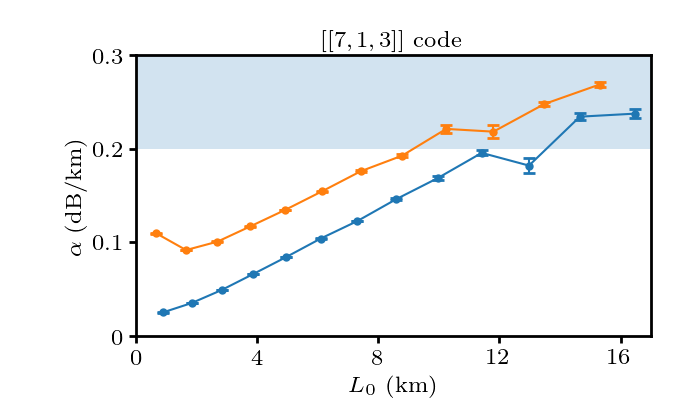

In [153]:
markersize_value = 4
capsize_value = 2
fig = plt.figure(figsize = (fig_width, fig_height))
with mpl.rc_context(pub_fig_style._get_revtex_rc()):
    import matplotlib.pylab as pylab
    params = {'legend.fontsize':'small',
             'axes.labelsize':'small',
             'axes.titlesize':'small',
             'xtick.labelsize':'small',
             'ytick.labelsize':'small'}
    pylab.rcParams.update(params)
    
    x_fill = np.arange(0.0,18,0.1)
    plt.fill_between(x_fill, 0.2,0.3, alpha=0.2)
    
    p_r_list = [0.1,0.05]
    legend_l = [r'$\eta_r=0.9$',r'$\eta_r=0.95$']
    start_ind = [3,2]
    for k_j in range(len(p_r_list)):
        alpha_list=alpha_list_tot[k_j]
        alpha_err_list=alpha_err_list_tot[k_j]
        L0_list = L0_list_tot[k_j]
        plt.errorbar(L0_list, alpha_list, yerr = alpha_err_list, marker='.', \
                     markersize = markersize_value, linestyle="none",capsize=capsize_value,color = 'C'+str(1-k_j))
        plt.plot(L0_list, alpha_list, '-', color = 'C'+str(1-k_j), label=legend_l[k_j])
    # p_r = 0 analytical solution:
    #f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 + 28 *x**4 * (1-x)**3 + 7*x**3 * (1-x)**4 
    #P_Pr0 = -10 / np.array(L0_list) * np.log10(f(10**(-0.02*np.array(L0_list))))
    #plt.plot(L0_list, P_Pr0, '-', label = r'$\eta_r = 1$', color = 'C0')
    #plt.plot(L0_list, P_Pr0, '.', marker='.', markersize = markersize_value, color = 'C0')
    #plt.legend(loc = "lower right",frameon=False,ncol=1)
    plt.xlim([0,17])
    plt.ylim([0,0.3])
    xtick = [0,4,8,12,16]
    xtick_labels = ['0','4','8','12','16']
    plt.xticks(xtick, xtick_labels)
    ytick = [0,0.1,0.2,0.3]
    ytick_labels = ['0','0.1','0.2','0.3']
    plt.yticks(ytick, ytick_labels)
    plt.xlabel(r'$L_0$ (km)')
    plt.ylabel(r'$\alpha$ (dB/km)')
    plt.title(r'$[[7,1,3]]$ code')
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig('Fig3_7q.pdf')
    plt.show()

## exponential decay plot

### 7q

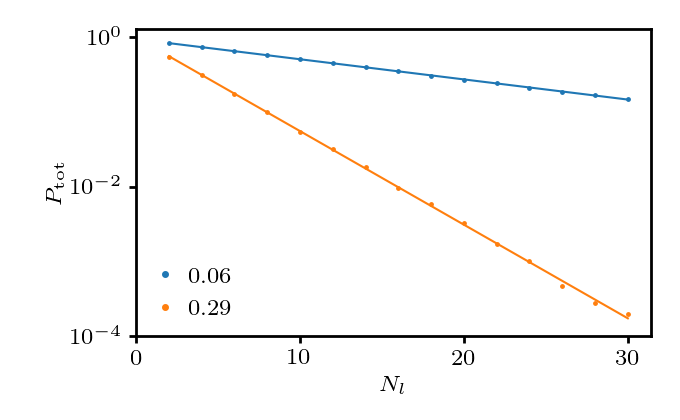

In [154]:
markersize_value = 4
capsize_value = 2
fig = plt.figure(figsize = (fig_width, fig_height))
with mpl.rc_context(pub_fig_style._get_revtex_rc()):
    import matplotlib.pylab as pylab
    params = {'legend.fontsize':'small',
             'axes.labelsize':'small',
             'axes.titlesize':'small',
             'xtick.labelsize':'small',
             'ytick.labelsize':'small'}
    pylab.rcParams.update(params)
    legend_l = [r'$\eta_r=0.9$',r'$\eta_r=0.95$']
    for k in range(len(exp_fit_inset)):
    #[Nl_fit_list[k],P_fit_list[k],m,b]
        exp_fit = exp_fit_inset[k]
        #Nl_l = exp_fit[0]
        Nl_l,Ptot_l,m,b = exp_fit[0],exp_fit[1],exp_fit[2],exp_fit[3]
        plt.plot(Nl_l,Ptot_l,'.',color = 'C'+str(k),label = str(abs(round(m,2))))
        plt.plot(Nl_l, np.exp(m*np.array(Nl_l)+b),'-',color = 'C'+str(k))
        plt.yscale("log")
    xtick = [0,10,20,30]
    xtick_labels = ['0','10','20','30']
    plt.xticks(xtick, xtick_labels)
    ytick = [1,1e-2,1e-4]
    ytick_labels = [r'$10^{0}$',r'$10^{-2}$',r'$10^{-4}$']
    plt.yticks(ytick, ytick_labels)
    plt.xlabel(r'$N_l$')
    plt.ylabel(r'$P_{\text{tot}}$')
    plt.legend()
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig('Fig3_inset_7q.pdf')
    plt.show()

# 48q decay slope

## data generation

In [155]:
p_r_list = [0.15,0.10,0.05]
legend_l = [r'$\eta_r=0.85$',r'$\eta_r=0.9$',r'$\eta_r=0.95$']
start_ind = [3,0,0]
exp_ind = [9,10,12]
exp_fit_inset=[]

alpha_list_tot = []
alpha_err_list_tot = []
L0_list_tot = []

for k_j in range(len(p_r_list)):
    p_r = p_r_list[k_j]
    p_repeater = 1 - p_r
    repeat = 200
    Nl_small = np.arange(2,9)
    Nl_large =  np.arange(12,25,4)
    Nl_list = np.concatenate((Nl_small,Nl_large))
    ind_p_list = np.arange(0,15,1)
    succ_prob_avg = np.zeros((len(ind_p_list),len(Nl_list)))

    bdy = True
    for i_L, Nl in enumerate(Nl_list):
        f1 = "data_48q/" + "even_Nl_%d" % (Nl)
        succ_prob_even,_, p_list_even, Ntot_even = file_reader_ldpc(f1,6,repeat,"even")
        succ_prob_repeater = succ_prob_even[np.argwhere(p_list_even==p_r)[0,:],:]            
        f2 = "data_48q/" + "odd_p_%.2f_Nl_%d" % (p_r,Nl)
        succ_prob_odd, _, p_list, Ntot = file_reader_ldpc(f2,6,repeat,"odd") 
        succ_prob_avg[:,i_L] = np.mean(succ_prob_odd[ind_p_list,:]*succ_prob_repeater ,axis=1)
    slope_list = []
    slope_err_list = []
    succ_prob_avg_avg_array = succ_prob_avg.T
    P_fit_list = []
    Nl_fit_list = []
    for k in range(succ_prob_avg_avg_array.shape[1]):
        P_fit1 = []
        Nl_fit1 = []
        for j in range(succ_prob_avg_avg_array.shape[0]):
            if succ_prob_avg_avg_array[j,k] > 0:
                P_fit1.append(succ_prob_avg_avg_array[j,k])
                Nl_fit1.append(Nl_list[j])
        P_fit_list.append(P_fit1)
        Nl_fit_list.append(Nl_fit1)

    Nl_tot = len(list(Nl_list))
    for k in range(start_ind[k_j],succ_prob_avg_avg_array.shape[1]):
        # linear regression to fit the exponential decay:
        m,b = np.polyfit(Nl_fit_list[k], np.log(P_fit_list[k]), 1)
        slope_list.append(abs(m))
        if k == exp_ind[k_j]:
            exp_fit_inset.append([Nl_fit_list[k],P_fit_list[k],m,b])
        # calculate the fitting slope error:
        yerr = m*np.array(Nl_fit_list[k])+b-np.array(np.log(P_fit_list[k]))
        N_len = len(Nl_fit_list[k])
        xavg_list = [sum(Nl_fit_list[k])/N_len]*N_len
        xerr = np.array(Nl_fit_list[k]) - np.array(xavg_list)
        slope_err = np.sqrt(1/N_len * sum(yerr**2) / sum(xerr**2) )
        slope_err_list.append(slope_err)

    A = np.log10((1-np.array(p_list[start_ind[k_j]:succ_prob_avg_avg_array.shape[1]]))/(1-p_r))
    L0_list=-50*A
    alpha_list=-0.2/np.log(10)*np.array(slope_list)/A
    alpha_err_list=-0.2/np.log(10)*np.array(slope_err_list)/A
    
    alpha_list_tot.append(alpha_list)
    alpha_err_list_tot.append(alpha_err_list)
    L0_list_tot.append(L0_list)

<ipython-input-155-d6aa85e871d3>:61: RuntimeWarning: divide by zero encountered in true_divide
  alpha_list=-0.2/np.log(10)*np.array(slope_list)/A
<ipython-input-155-d6aa85e871d3>:62: RuntimeWarning: divide by zero encountered in true_divide
  alpha_err_list=-0.2/np.log(10)*np.array(slope_err_list)/A


## plot

C:\Users\Daoheng Niu\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:3323: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


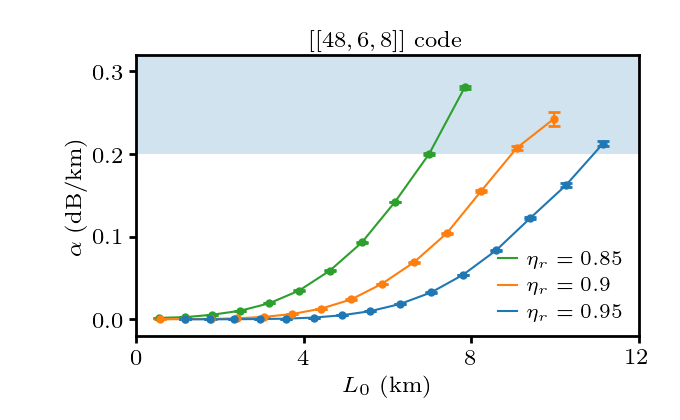

In [143]:
markersize_value = 4
capsize_value = 2
fig = plt.figure(figsize = (fig_width, fig_height))
with mpl.rc_context(pub_fig_style._get_revtex_rc()):
    import matplotlib.pylab as pylab
    params = {'legend.fontsize':'x-small',
             'axes.labelsize':'small',
             'axes.titlesize':'small',
             'xtick.labelsize':'small',
             'ytick.labelsize':'small'}
    pylab.rcParams.update(params)
    
    x_fill = np.arange(0.0,13,0.1)
    plt.fill_between(x_fill, 0.2,0.32, alpha=0.2)
    
    p_r_list = [0.15,0.10,0.05]
    legend_l = [r'$\eta_r=0.85$',r'$\eta_r=0.9$',r'$\eta_r=0.95$']
    start_ind = [3,0,0]
    for k_j in range(len(p_r_list)):
        alpha_list=alpha_list_tot[k_j]
        alpha_err_list=alpha_err_list_tot[k_j]
        L0_list = L0_list_tot[k_j]
        if k_j == 0:
            plt.errorbar(L0_list[0:-1], alpha_list[0:-1], yerr = alpha_err_list[0:-1], marker='.', \
                         markersize = markersize_value, linestyle="none",color = 'C'+str(2-k_j),capsize=capsize_value)
            plt.plot(L0_list[0:-1], alpha_list[0:-1], '-', color = 'C'+str(2-k_j), label=legend_l[k_j])
        else:
            plt.errorbar(L0_list, alpha_list, yerr = alpha_err_list, marker='.', \
                         markersize = markersize_value, linestyle="none",color = 'C'+str(2-k_j),capsize=capsize_value)
            plt.plot(L0_list, alpha_list, '-', color = 'C'+str(2-k_j), label=legend_l[k_j])
    plt.legend(loc = "lower right",frameon=False,ncol=1)
    plt.xlim([0,12])
    plt.ylim([-0.02,0.32])
    xtick = [0,4,8,12]
    xtick_labels = ['0','4','8','12']
    plt.xticks(xtick, xtick_labels)
    plt.xlabel(r'$L_0$ (km)')
    plt.ylabel(r'$\alpha$ (dB/km)')
    plt.title(r'$[[48,6,8]]$ code')
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig('Fig3_new_48q_2.pdf')
    plt.show()

## exponential decay plot

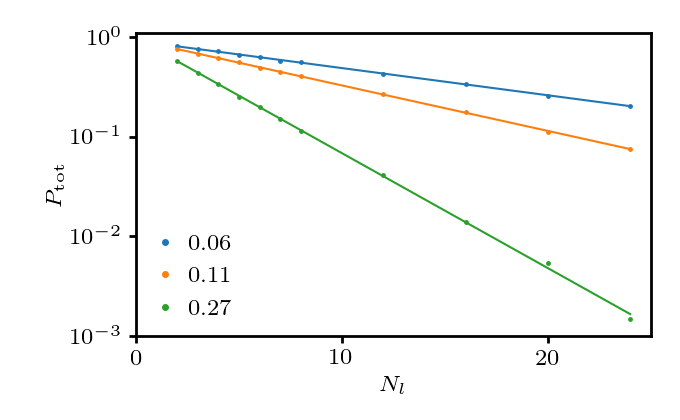

In [149]:
markersize_value = 4
capsize_value = 2
fig = plt.figure(figsize = (fig_width, fig_height))
with mpl.rc_context(pub_fig_style._get_revtex_rc()):
    import matplotlib.pylab as pylab
    params = {'legend.fontsize':'small',
             'axes.labelsize':'small',
             'axes.titlesize':'small',
             'xtick.labelsize':'small',
             'ytick.labelsize':'small'}
    pylab.rcParams.update(params)
    legend_l = [r'$\eta_r=0.9$',r'$\eta_r=0.95$']
    for k in range(len(exp_fit_inset)):
    #[Nl_fit_list[k],P_fit_list[k],m,b]
        exp_fit = exp_fit_inset[k]
        #Nl_l = exp_fit[0]
        Nl_l,Ptot_l,m,b = exp_fit[0],exp_fit[1],exp_fit[2],exp_fit[3]
        plt.plot(Nl_l,Ptot_l,'.',color = 'C'+str(k),label = str(abs(round(m,2))))
        plt.plot(Nl_l, np.exp(m*np.array(Nl_l)+b),'-',color = 'C'+str(k))
        plt.yscale("log")
    xtick = [0,10,20,30]
    xtick_labels = ['0','10','20','30']
    plt.xticks(xtick, xtick_labels)
    ytick = [1,1e-1, 1e-2,1e-3]
    ytick_labels = [r'$10^{0}$',r'$10^{-1}$',r'$10^{-2}$',r'$10^{-3}$']
    plt.yticks(ytick, ytick_labels)
    plt.xlabel(r'$N_l$')
    plt.ylabel(r'$P_{\text{tot}}$')
    plt.xlim([0,25])
    plt.legend()
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig('Fig3_inset_48q.pdf')
    plt.show()

# 48q decay

In [59]:
Nl_list_large = []
tot_layer = 1000
for k in range(2,tot_layer):
    Nl_list_large.append((k+1))
    
from scipy.interpolate import interp1d
L_sep = list(np.arange(1,15,1))
Layer_num = tot_layer
layer_list = list(np.arange(2,Layer_num,1))
L_tot_list = []
for k in L_sep:
    L_tot_list.append(list(np.array(layer_list) * k))
L_tot_array = np.array(L_tot_list)

p_r_list = [0.15,0.10,0.05]
legend_l = [r'$\eta_r=0.85$',r'$\eta_r=0.9$',r'$\eta_r=0.95$']
fname_l = ["48q_pr85_Fig3.npz","48q_pr90_Fig3.npz","48q_pr95_Fig3.npz"]
start_ind = [0,0,0]

for k_j in range(len(p_r_list)):
    p_r = p_r_list[k_j]
    p_repeater = 1 - p_r
    repeat = 200
    Nl_small = np.arange(2,9)
    Nl_large =  np.arange(12,25,4)
    Nl_list = np.concatenate((Nl_small,Nl_large))
    ind_p_list = np.arange(0,20,1)
    succ_prob_avg = np.zeros((len(ind_p_list),len(Nl_list)))

    bdy = True
    for i_L, Nl in enumerate(Nl_list):
        f1 = "data_48q/" + "even_Nl_%d" % (Nl)
        succ_prob_even,_, p_list_even, Ntot_even = file_reader_ldpc(f1,6,repeat,"even")
        succ_prob_repeater = succ_prob_even[np.argwhere(p_list_even==p_r)[0,:],:]            
        f2 = "data_48q/" + "odd_p_%.2f_Nl_%d" % (p_r,Nl)
        succ_prob_odd, _, p_list, Ntot = file_reader_ldpc(f2,6,repeat,"odd") 
        succ_prob_avg[:,i_L] = np.mean(succ_prob_odd[ind_p_list,:]*succ_prob_repeater ,axis=1)
    succ_prob_avg_avg_array = succ_prob_avg.T
    slope_list = []
    slope_err_list = []
    succ_prob_avg_avg_array = succ_prob_avg.T
    P_fit_list = []
    Nl_fit_list = []
    for k in range(succ_prob_avg_avg_array.shape[1]):
        P_fit1 = []
        Nl_fit1 = []
        for j in range(succ_prob_avg_avg_array.shape[0]):
            if succ_prob_avg_avg_array[j,k] > 0:
                P_fit1.append(succ_prob_avg_avg_array[j,k])
                Nl_fit1.append(Nl_list[j])
        P_fit_list.append(P_fit1)
        Nl_fit_list.append(Nl_fit1)

    Nl_tot = len(list(Nl_list))
    succ_prob_tot = []
    for k in range(start_ind[k_j],succ_prob_avg_avg_array.shape[1]):
        # linear regression to fit the exponential decay:
        m,b = np.polyfit(Nl_fit_list[k], np.log(P_fit_list[k]), 1)
        succ_prob_tot.append(list(np.exp(m * np.array(Nl_list_large) + b)))
    succ_prob_tot_array = np.array(succ_prob_tot)
    
    fname = fname_l[k_j]    
    P_numrep_L = []    
    succ_prob_avg_avg_list = list(succ_prob_tot_array.T)
    t_list = 1-np.array(p_list)
    t_list = list(t_list)
    t_list.append(0)
    t_list.reverse()
    t_list.append(1)
    for k in range(0,len(succ_prob_avg_avg_list)):
        succ_prob_avg_avg_list0 = list(succ_prob_avg_avg_list[k].copy())
        succ_prob_avg_avg_list0.append(0)
        succ_prob_avg_avg_list0.reverse()
        succ_prob_avg_avg_list0.append(1)
        Num_repeater = Nl_list_large[k]
        P_eff_interpolate = interp1d(t_list, succ_prob_avg_avg_list0)
        p_keep = p_repeater * 10 ** (-0.02*L_tot_array[:,k]/Num_repeater)
        P_numrep_L.append(list(P_eff_interpolate(p_keep)))
    P_numrep_L = np.array(P_numrep_L)
    np.savez(fname, P_numrep_L=P_numrep_L, L_tot_array=L_tot_array)

(998, 14) (14, 998)


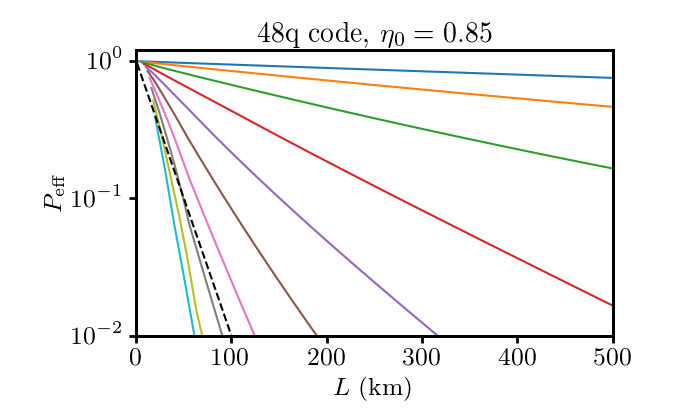

(998, 14) (14, 998)


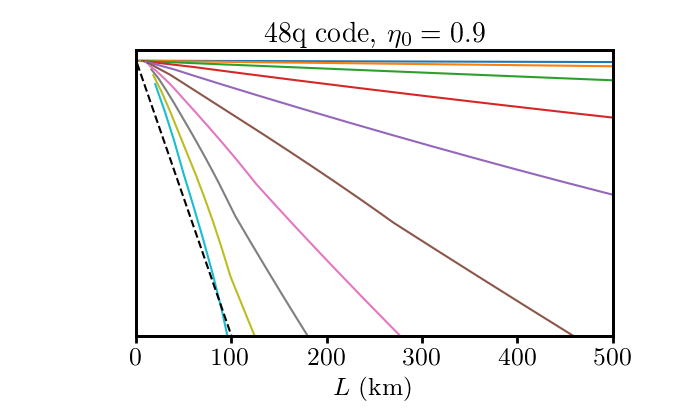

(998, 14) (14, 998)


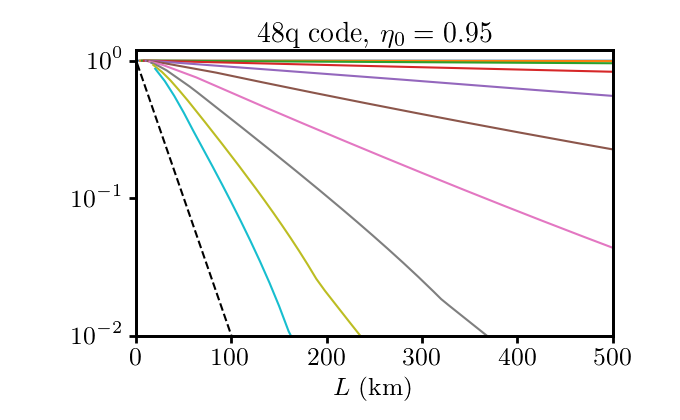

In [63]:
filename_l = ["48q_pr85_Fig3.npz","48q_pr90_Fig3.npz","48q_pr95_Fig3.npz"]
legend_l = ['$\eta_0 = 0.85$','$\eta_0 = 0.9$','$\eta_0 = 0.95$']
label_L0 = ['1','2','3','4','5','6','7','8','9','10']
L_tot1 = 10**(np.arange(0,4,0.02))
P_DT = 10**(-0.02*L_tot1)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for k in range(len(filename_l)):
    fig = plt.figure(figsize = (fig_width, fig_height))
    with mpl.rc_context(pub_fig_style._get_revtex_rc()):
        ax1 = fig.add_subplot(111)
        fname = filename_l[k]
        if os.path.exists(fname):
            npz_file = np.load(fname)
            P_numrep_L, L_tot_array = \
            npz_file['P_numrep_L'], npz_file['L_tot_array']
            print(P_numrep_L.shape, L_tot_array.shape)

            #for p_l in range(L_tot_array.shape[0]):
            for p_l in range(10):
                ax1.plot(L_tot_array[p_l,:],P_numrep_L[:,p_l],\
                         label='$L_0=$'+label_L0[p_l] +'km',color="C%d" % (p_l))
            ax1.plot(L_tot1, P_DT, 'k--', label = 'Direct transmission')
        ax1.set_xlabel(r"$L$ (km)")
        #ax1.set_ylabel("Effective transmission $P_{eff}$")
        ax1.set_yscale("log")
        if k == 0:
            ax1.set_ylabel(r"$P_{\text{eff}}$")
        if k == 1:
            ax1.set_yticks([])
        #if  k == 1:
        #    ax1.legend(frameon=False,fontsize='large', ncol=1)
        ax1.set_xlim([0, 500])
        ax1.set_ylim([1e-2, 1.2])
        ax2 = ax1.twiny()
        ax2.set_xlim(0, 10000)
        ax2.set_xticks([])
        ax1.set_title('48q code, ' + legend_l[k])
        #ax2.set_xlabel("total distance (km)")
        plt.gcf().subplots_adjust(bottom=0.2)
        plt.gcf().subplots_adjust(left=0.2)
        plt.savefig(str(k)+'_48q_Fig3_v5.pdf')
        plt.show()

# 7q decay

In [46]:
Nl_list_large = []
tot_layer = 1000
for k in range(2,tot_layer):
    Nl_list_large.append((k+1))
    
from scipy.interpolate import interp1d
L_sep = list(np.arange(1,15,1))
Layer_num = tot_layer
layer_list = list(np.arange(2,Layer_num,1))
L_tot_list = []
for k in L_sep:
    L_tot_list.append(list(np.array(layer_list) * k))
L_tot_array = np.array(L_tot_list)

p_r_list = [0.10,0.05]
legend_l = [r'$\eta_r=0.9$',r'$\eta_r=0.95$']
fname_l = ["7q_pr90_Fig3.npz","7q_pr95_Fig3.npz"]
start_ind = [0,0]

for k_j in range(len(p_r_list)):
    p_r = p_r_list[k_j]
    p_repeater = 1 - p_r
    
    repeat = 100
    p_r = p_r_list[k_j]
    Nl_list = np.arange(2,31,2)
    ind_p_list = np.arange(0,20,1)
    succ_prob_avg = np.zeros((len(ind_p_list),len(Nl_list)))

    bdy = True
    for i_L, Nl in enumerate(Nl_list):
        f1 = "data_7q/" + "even_Nl_%d" % (Nl)
        # f1 = "old_data/data_7q/" + "obc_Nl_%d" % (Nl)
        succ_prob_even, p_list_even, Ntot_even = file_reader(f1,repeat) 
        succ_prob_repeater = succ_prob_even[np.argwhere(p_list_even==p_r)]
        # succ_prob_repeater = np.interp(p_r,p_list_even, succ_prob_even)

        # f2 = "old_data/data_7q/" + "obc_p_%.2f_Nl_%d" % (p_r,Nl)
        f2 = "data_7q/" + "odd_p_%.2f_Nl_%d" % (p_r,Nl)
        succ_prob_odd, p_list, Ntot = file_reader(f2,repeat) 
        succ_prob_avg[:,i_L] = succ_prob_odd[ind_p_list]*succ_prob_repeater

    succ_prob_avg_avg_array = succ_prob_avg.T
    slope_list = []
    slope_err_list = []
    succ_prob_avg_avg_array = succ_prob_avg.T
    P_fit_list = []
    Nl_fit_list = []
    for k in range(succ_prob_avg_avg_array.shape[1]):
        P_fit1 = []
        Nl_fit1 = []
        for j in range(succ_prob_avg_avg_array.shape[0]):
            if succ_prob_avg_avg_array[j,k] > 0:
                P_fit1.append(succ_prob_avg_avg_array[j,k])
                Nl_fit1.append(Nl_list[j])
        P_fit_list.append(P_fit1)
        Nl_fit_list.append(Nl_fit1)

    Nl_tot = len(list(Nl_list))
    succ_prob_tot = []
    for k in range(start_ind[k_j],succ_prob_avg_avg_array.shape[1]):
        # linear regression to fit the exponential decay:
        m,b = np.polyfit(Nl_fit_list[k], np.log(P_fit_list[k]), 1)
        succ_prob_tot.append(list(np.exp(m * np.array(Nl_list_large) + b)))
    succ_prob_tot_array = np.array(succ_prob_tot)
    
    fname = fname_l[k_j]    
    P_numrep_L = []    
    succ_prob_avg_avg_list = list(succ_prob_tot_array.T)
    t_list = 1-np.array(p_list)
    t_list = list(t_list)
    t_list.append(0)
    t_list.reverse()
    t_list.append(1)
    for k in range(0,len(succ_prob_avg_avg_list)):
        succ_prob_avg_avg_list0 = list(succ_prob_avg_avg_list[k].copy())
        succ_prob_avg_avg_list0.append(0)
        succ_prob_avg_avg_list0.reverse()
        succ_prob_avg_avg_list0.append(1)
        Num_repeater = Nl_list_large[k]
        P_eff_interpolate = interp1d(t_list, succ_prob_avg_avg_list0)
        p_keep = p_repeater * 10 ** (-0.02*L_tot_array[:,k]/Num_repeater)
        P_numrep_L.append(list(P_eff_interpolate(p_keep)))
    P_numrep_L = np.array(P_numrep_L)
    np.savez(fname, P_numrep_L=P_numrep_L, L_tot_array=L_tot_array)

(998, 14) (14, 998)


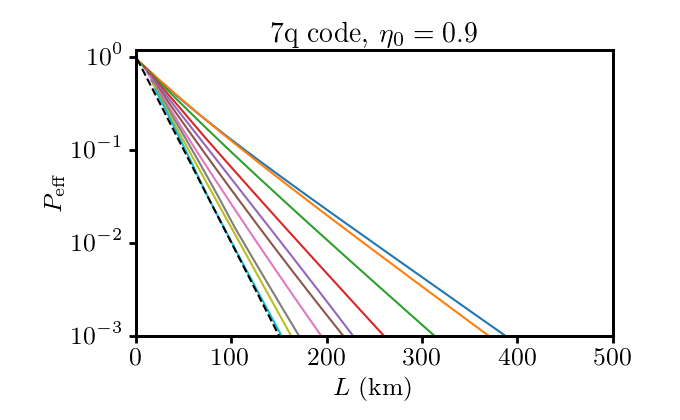

(998, 14) (14, 998)


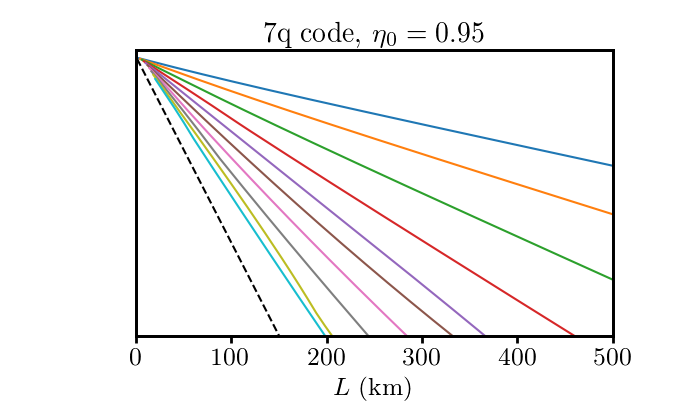

In [64]:
filename_l = ["7q_pr90_Fig3.npz","7q_pr95_Fig3.npz"]
legend_l = ['$\eta_0 = 0.9$','$\eta_0 = 0.95$']
label_L0 = ['1','2','3','4','5','6','7','8','9','10']
L_tot1 = 10**(np.arange(0,4,0.02))
P_DT = 10**(-0.02*L_tot1)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          #'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for k in range(len(filename_l)):
    fig = plt.figure(figsize = (fig_width, fig_height))
    with mpl.rc_context(pub_fig_style._get_revtex_rc()):
        ax1 = fig.add_subplot(111)
        fname = filename_l[k]
        if os.path.exists(fname):
            npz_file = np.load(fname)
            P_numrep_L, L_tot_array = \
            npz_file['P_numrep_L'], npz_file['L_tot_array']
            print(P_numrep_L.shape, L_tot_array.shape)
            #for p_l in range(L_tot_array.shape[0]):
            for p_l in range(10):
                ax1.plot(L_tot_array[p_l,:],P_numrep_L[:,p_l],\
                         label='$L_0=$'+label_L0[p_l] +'km',color="C%d" % (p_l))
            ax1.plot(L_tot1, P_DT, 'k--', label = 'Direct transmission')
        ax1.set_xlabel(r"$L$ (km)")
        #ax1.set_ylabel("Effective transmission $P_{eff}$")
        ax1.set_yscale("log")
        if k == 0:
            ax1.set_ylabel(r"$P_{\text{eff}}$")
        if k == 1:
            ax1.set_yticks([])
        #if  k == 1:
        #    ax1.legend(frameon=False,fontsize='large', ncol=1)
        ax1.set_xlim([0, 500])
        ax1.set_ylim([1e-3, 1.2])
        ax2 = ax1.twiny()
        ax2.set_xlim(0, 10000)
        ax2.set_xticks([])
        ax1.set_title('7q code, ' + legend_l[k])
        #ax2.set_xlabel("total distance (km)")
        plt.gcf().subplots_adjust(bottom=0.2)
        plt.gcf().subplots_adjust(left=0.2)
        plt.savefig(str(k)+'_7q_Fig3_v5.pdf')
        plt.show()